In [177]:
#Importing libraries
import pandas as pd 
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.io import read_image
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import time

## Reading files and preprocessing


In [2]:
labels= pd.read_csv("data_labels.csv")

In [3]:
#Dropping nan values
labels=labels.dropna()

## Image processing

In [4]:
from PIL import Image
import os, sys

In [5]:
#adding image names to a list from the dataframe
image_new= labels['Image_name']
image_new=image_new.tolist()

In [6]:
for i in image_new:
    image = Image.open("Images/"+i+".jpg")
    #resizing the image to 120x120
    image = image.resize((36,36),Image.ANTIALIAS)
    #converting to RGB AND PNG(image-type)
    image = image.convert('RGB')
    new_name = i.split('.')[0]+".png"
    #saving the processed images in a new file
    image.save(fp="new_images/"+new_name)

# Step 1 : 
## Sampling

In [7]:
image_array = []
for i in image_new:
    image = Image.open("new_images/"+i+'.png')
    data = np.asarray(image)
    image_array.append(data)

In [8]:
image_array = np.asarray(image_array)
image_array.shape

(516, 36, 36, 3)

In [9]:
f_array=[]
for i in image_array:
    flatten_array=i.flatten()
    f_array.append(flatten_array)

In [10]:
print(f_array)

[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 1], dtype=uint8), array([0, 0, 0, ..., 0, 0, 1], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 3, ..., 0, 0, 4], dtype=uint8), array([0, 0, 1, ..., 0, 0, 0], dtype=uint8), array([0, 0, 2, ..., 0, 0, 3], dtype=uint8), array([0, 0, 0, ..., 0, 0, 1], dtype=uint8), array([0, 0, 3, ..., 0, 0, 3], dtype=uint8), array([0, 0, 1, ..., 0, 0, 1], dtype=uint8), array([0, 0, 1, ..., 0, 0, 2], dtype=uint8), array([0, 0, 0, ..., 0, 0, 1], dtype=uint8), array([1, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 2, ..., 0, 0, 3], dtype=uint8), array([0, 0, 0, ..., 0, 0, 2], dtype=uint8), array([0, 0, 3, ..., 0, 0, 2], dtype=uint8), array([3, 0, 1, ..., 0, 0, 4], dtype=uint8), array([1, 0, 0, ..., 0, 0, 2], dtype=uint8), array([0, 0, 1, ..., 0, 0, 1], dtype=uint8), array([3, 0, 1, ..., 0, 0, 1], dtype=uint8), array([0, 0, 0, ..., 1, 0, 0], dtype=uint8), array([0,

# K Elbow Visualizer

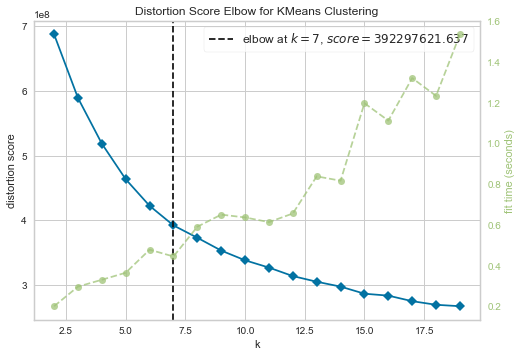

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
f2_array= np.array(f_array)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(f2_array)
visualizer.show()

In [12]:
def KMEANS(f2_array,labels):
    kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=0).fit(f2_array)
    predictions = kmeans.predict(f2_array)
    labels['class_K'] = predictions
    unique = labels['class_K'].unique()
    
    return predictions,unique

In [13]:
predictions,unique=KMEANS(f2_array,labels)

In [14]:
print(unique)

[5 2 0 1 3 6 4]


In [15]:
def sampling(labels):
    sampling = []
    for i in unique:
        temp = labels[ labels['class_K'] == i ]
        temp = temp.sample(frac = 0.7)
        sampling.append(temp)
    return sampling

In [16]:
sampled_data=sampling(labels)


In [17]:
df = pd.concat(sampled_data)

In [18]:
df

,Image_name,level,class_K
229,IMG_230,2,5
132,IMG_133,4,5
255,IMG_256,0,5
111,IMG_112,3,5
50,IMG_51,2,5
...,...,...,...
395,IMG_396,2,4
168,IMG_169,3,4
465,IMG_466,2,4
161,IMG_162,2,4


In [200]:
#for time calculation of each model.
time_model=[]
time_model2=[]

# Step 2
## Segmentation

In [19]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [38]:
def segmentation(new_images):
    for i in new_images:
        image = cv2.imread('new_images/'+i+'.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
        pixel_vals = image
        # Convert to float type
        pixel_vals = np.float32(pixel_vals)
        """Iterations=200 and accuracy 85% is the criteria"""
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.85) 
        """ K-means clustering on k = 6 and random centers"""
        k = 7
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # converting the  data into 8-bit values
        centers = np.uint8(centers)
        segmented_data = centers[labels.flatten()]
        segmented_image = segmented_data.reshape((image.shape))
        plt.imshow(segmented_image)
        cv2.imwrite('segmented_images/'+i+'.png',segmented_image)

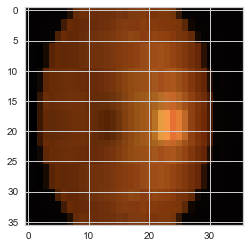

In [39]:
segmentation(image_new)

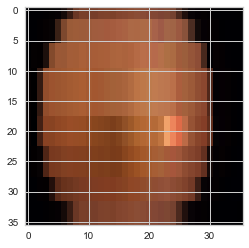

In [42]:
image = cv2.imread('new_images/IMG_10.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image
# Convert to float type
pixel_vals = np.float32(pixel_vals)
"""Iterations=200 and accuracy 85% is the criteria"""
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.85) 
""" K-means clustering on k = 6 and random centers"""
k = 7
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
# converting the  data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((image.shape))
plt.imshow(segmented_image)

# Step 3 


## (i) Split the data into test and train

In [43]:
from numpy.random import RandomState
rng = RandomState()
train = df.sample(frac=0.7, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

In [44]:
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)

## (ii) ML model Logistic Regression (non-segmented images)

In [45]:
def imageselection(x,y,n):
    count = np.zeros(10)
    lim = n / 10
    x1 = []
    y1 = []
    for i in range(10):
        for j in range(x.shape[0]):
            if(count[i] == lim):
                break
            else:
                if(y[j] == i):
                    count[i] += 1
                    x1.append(x[j])
                    y1.append(y[j])
    x2=np.array(x1)
    y2=np.array(y1)
    return x2,y2

In [46]:
df_label= list(df['level'])
def read_seg(new_images):
    seg=[]
    for i in new_images:
        image = Image.open("new_images/"+i+'.png')
        image1 = np.asarray(image)
        seg.append(image1)
    return seg

In [47]:
segment=read_seg(df['Image_name'])

In [48]:
x_train,y_train = segment[0:250],df_label[0:250]

In [49]:
x_test,y_test = segment[250:],df_label[250:]

In [50]:
def flatten(x):
    b = x.flatten()
    return b

In [51]:
def normalize(label):
    X = []
    [X.append(flatten(i)) for i in label]
    X = np.array(X)
    return X

X= normalize(x_train)
X_TEST=normalize(x_test)

In [52]:
from sklearn.linear_model import LogisticRegression

## Training  

In [201]:
seconds = time.time()
clf_logistic = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X,y_train)
time_model.append(time.time()-seconds)

/Users/aqsarahman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
val_predictions = clf_logistic.predict(X_TEST)

In [55]:
from sklearn.metrics import accuracy_score

In [56]:
logreg_acc = accuracy_score(y_test, val_predictions)

In [57]:
print("Logistic Regression Accuracy on non-segmented: ")
print(logreg_acc * 100)

Logistic Regression Accuracy on non-segmented: 
41.07142857142857


## ML model naive bayes (nonn-segmented)

In [58]:
from sklearn.naive_bayes import GaussianNB

In [59]:
gnb = GaussianNB()

In [202]:
seconds = time.time()
gnb.fit(X,y_train)
time_model.append(time.time()-seconds)

In [61]:
val_predictions = gnb.predict(X_TEST)

In [62]:
acc = accuracy_score(y_test, val_predictions)

In [63]:
print("NAIVE BAYES Accuracy non-segmented: ")
print(acc * 100,'%')

NAIVE BAYES Accuracy non-segmented: 
33.92857142857143 %


## (iii) ML model Logistic Regression (segmented images)


In [64]:
def imageselection(x,y,n):
    count = np.zeros(10)
    lim = n / 10
    x1 = []
    y1 = []
    for i in range(10):
        for j in range(x.shape[0]):
            if(count[i] == lim):
                break
            else:
                if(y[j] == i):
                    count[i] += 1
                    x1.append(x[j])
                    y1.append(y[j])
    x2=np.array(x1)
    y2=np.array(y1)
    return x2,y2
    


In [65]:
df_label= list(df['level'])
def read_seg(segmented_images):
    seg=[]
    for i in segmented_images:
        image = Image.open("segmented_images/"+i+'.png')
        image1 = np.asarray(image)
        seg.append(image1)
    return seg


In [66]:
segment=read_seg(df['Image_name'])

In [67]:
x_train,y_train = segment[0:250],df_label[0:250]

In [68]:
x_test,y_test = segment[250:],df_label[250:]

In [69]:
def flatten(x):
    b = x.flatten()
    return b

In [70]:
def normalize(label):
    X = []
    [X.append(flatten(i)) for i in label]
    X = np.array(X)
    return X

X= normalize(x_train)
X_TEST=normalize(x_test)

In [71]:
from sklearn.linear_model import LogisticRegression

In [203]:
seconds = time.time()
clf_logistic = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X,y_train)
time_model2.append(time.time()-seconds)

/Users/aqsarahman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [73]:
val_predictions = clf_logistic.predict(X_TEST)

In [74]:
from sklearn.metrics import accuracy_score

In [75]:
logreg_acc = accuracy_score(y_test, val_predictions)

In [76]:
print("Logistic Regression Accuracy on Segmented images: ")
print(logreg_acc * 100)

Logistic Regression Accuracy on Segmented images: 
41.07142857142857


## (vi) ML model Naive Bayes (Segmented)

In [77]:
from sklearn.naive_bayes import GaussianNB

In [78]:
gnb = GaussianNB()

In [204]:
seconds = time.time()
gnb.fit(X,y_train)
time_model2.append(time.time()-seconds)

In [80]:
val_predictions = gnb.predict(X_TEST)

In [81]:
acc = accuracy_score(y_test, val_predictions)

In [82]:
print("NAIVE BAYES Accuracy Segmented: ")
print(acc * 100,'%')

NAIVE BAYES Accuracy Segmented: 
33.92857142857143 %


## (iv) Neural Network ANN (segmented)

### Data loader  

In [97]:
""" Neural network (ANN) for images data to classify in 7 labels"""
from torch.utils.data import Dataset
class Dataset_loader(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        train_labels = pd.read_csv(annotations_file)
        labels_images = [i for i in train_labels['level']]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.png')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        text = self.img_labels.iloc[idx, 1]
        array = torch.as_tensor(label)
        x=image.float()
        return x,array

In [98]:
def loader():
    train = Dataset_loader(annotations_file="train.csv",img_dir="./segmented_images")
    test = Dataset_loader(annotations_file="test.csv",img_dir="./segmented_images")
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16,num_workers=0,pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)
    return train_dataloader,test_dataloader

In [99]:
train_dataloader,test_dataloader = loader()

In [100]:
test = Dataset_loader(annotations_file="test.csv",img_dir="./segmented_images")

##  ANN

In [110]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3888,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 7)
    
    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
       
        

        x =self.fc3(x)
        return x
image_net = Net()


In [111]:
Net()

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3888, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)

## Loss function

In [112]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_net.parameters(), lr=0.001)

## Training

In [205]:
seconds = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = image_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2 == 0:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0
time_model2.append(time.time()-seconds)

[1,     1] loss: 0.196
[1,     3] loss: 1.038
[1,     5] loss: 0.735
[1,     7] loss: 1.216
[1,     9] loss: 1.069
[1,    11] loss: 0.926
[1,    13] loss: 0.814
[1,    15] loss: 0.717
[2,     1] loss: 0.196
[2,     3] loss: 1.038
[2,     5] loss: 0.735
[2,     7] loss: 1.216
[2,     9] loss: 1.069
[2,    11] loss: 0.926
[2,    13] loss: 0.814
[2,    15] loss: 0.717
[3,     1] loss: 0.196
[3,     3] loss: 1.038
[3,     5] loss: 0.735
[3,     7] loss: 1.216
[3,     9] loss: 1.069
[3,    11] loss: 0.926
[3,    13] loss: 0.814
[3,    15] loss: 0.717
[4,     1] loss: 0.196
[4,     3] loss: 1.038
[4,     5] loss: 0.735
[4,     7] loss: 1.216
[4,     9] loss: 1.069
[4,    11] loss: 0.926
[4,    13] loss: 0.814
[4,    15] loss: 0.717
[5,     1] loss: 0.196
[5,     3] loss: 1.038
[5,     5] loss: 0.735
[5,     7] loss: 1.216
[5,     9] loss: 1.069
[5,    11] loss: 0.926
[5,    13] loss: 0.814
[5,    15] loss: 0.717
[6,     1] loss: 0.196
[6,     3] loss: 1.038
[6,     5] loss: 0.735
[6,     7] 

In [116]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs,labels = data
        outputs = image_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy  = {100 * correct // total } percent')

Accuracy  = 68 percent


## CNN  (Segmented)

In [130]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 7)  
        self.conv2 = nn.Conv2d(10, 21, 5)
        self.pool = nn.MaxPool2d(2, stride=1) 
        self.pool2 = nn.MaxPool2d(4, stride=2) 
        self.fc1 = nn.Linear(2541, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7) 



    def forward(self, x):
        z = nn.functional.relu(self.conv1(x))  
        z = self.pool(z)                         
        z = nn.functional.relu(self.conv2(z))
        z = self.pool2(z)                         
        
        z = torch.flatten(z, 1)   
        z = nn.functional.relu(self.fc1(z))
        z = nn.functional.relu(self.fc2(z))
        z = self.fc3(z)
        return z
    
cnn_net=Net()

## loss function

In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net.parameters(), lr=0.001)

## Training

In [206]:
# Training
seconds = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = cnn_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2 == 0:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0
time_model2.append(time.time()-seconds)

[1,     1] loss: 0.000
[1,     3] loss: 0.001
[1,     5] loss: 0.000
[1,     7] loss: 0.001
[1,     9] loss: 0.001
[1,    11] loss: 0.001
[1,    13] loss: 0.001
[1,    15] loss: 0.000
[2,     1] loss: 0.000
[2,     3] loss: 0.001
[2,     5] loss: 0.000
[2,     7] loss: 0.001
[2,     9] loss: 0.001
[2,    11] loss: 0.001
[2,    13] loss: 0.001
[2,    15] loss: 0.000
[3,     1] loss: 0.000
[3,     3] loss: 0.001
[3,     5] loss: 0.000
[3,     7] loss: 0.001
[3,     9] loss: 0.000
[3,    11] loss: 0.000
[3,    13] loss: 0.001
[3,    15] loss: 0.000
[4,     1] loss: 0.000
[4,     3] loss: 0.001
[4,     5] loss: 0.000
[4,     7] loss: 0.001
[4,     9] loss: 0.000
[4,    11] loss: 0.000
[4,    13] loss: 0.001
[4,    15] loss: 0.000
[5,     1] loss: 0.000
[5,     3] loss: 0.001
[5,     5] loss: 0.000
[5,     7] loss: 0.001
[5,     9] loss: 0.000
[5,    11] loss: 0.000
[5,    13] loss: 0.000
[5,    15] loss: 0.000
[6,     1] loss: 0.000
[6,     3] loss: 0.001
[6,     5] loss: 0.000
[6,     7] 

In [133]:
# Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs =cnn_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc=100 * correct // total

print(f'Accuracy of the network on test images: {acc} %')

Accuracy of the network on test images: 66 %


## ANN for non-segmented images

## Data loader

In [136]:
""" Neural network (ANN) for images data to classify in 7 labels"""
from torch.utils.data import Dataset
class Dataset_loader(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        train_labels = pd.read_csv(annotations_file)
        labels_images = [i for i in train_labels['level']]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.png')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        text = self.img_labels.iloc[idx, 1]
        array = torch.as_tensor(label)
        x=image.float()
        return x,array

In [137]:
def loader():
    train = Dataset_loader(annotations_file="train.csv",img_dir="./new_images")
    test = Dataset_loader(annotations_file="test.csv",img_dir="./new_images")
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16,num_workers=0,pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)
    return train_dataloader,test_dataloader

In [138]:
train_dataloader,test_dataloader = loader()

In [139]:
test = Dataset_loader(annotations_file="test.csv",img_dir="./new_images")

In [158]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3888,1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 7)
    
    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
    
        x =self.fc3(x)
        return x
image_net = Net()


In [159]:
Net()

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3888, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)

## Loss function

In [160]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_net.parameters(), lr=0.001)

## Training

In [207]:
seconds = time.time()
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = image_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2 == 0:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0
time_model.append(time.time()-seconds)

[1,     1] loss: 0.196
[1,     3] loss: 1.038
[1,     5] loss: 0.735
[1,     7] loss: 1.216
[1,     9] loss: 1.069
[1,    11] loss: 0.926
[1,    13] loss: 0.814
[1,    15] loss: 0.717
[2,     1] loss: 0.196
[2,     3] loss: 1.038
[2,     5] loss: 0.735
[2,     7] loss: 1.216
[2,     9] loss: 1.069
[2,    11] loss: 0.926
[2,    13] loss: 0.814
[2,    15] loss: 0.717
[3,     1] loss: 0.196
[3,     3] loss: 1.038
[3,     5] loss: 0.735
[3,     7] loss: 1.216
[3,     9] loss: 1.069
[3,    11] loss: 0.926
[3,    13] loss: 0.814
[3,    15] loss: 0.717
[4,     1] loss: 0.196
[4,     3] loss: 1.038
[4,     5] loss: 0.735
[4,     7] loss: 1.216
[4,     9] loss: 1.069
[4,    11] loss: 0.926
[4,    13] loss: 0.814
[4,    15] loss: 0.717
[5,     1] loss: 0.196
[5,     3] loss: 1.038
[5,     5] loss: 0.735
[5,     7] loss: 1.216
[5,     9] loss: 1.069
[5,    11] loss: 0.926
[5,    13] loss: 0.814
[5,    15] loss: 0.717
[6,     1] loss: 0.196
[6,     3] loss: 1.038
[6,     5] loss: 0.735
[6,     7] 

In [162]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs,labels = data
        outputs = image_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of ANN non-segmented = {100 * correct // total } percent')

Accuracy of ANN non-segmented = 55 percent


## CNN (non-segmented images)

In [168]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 7)  
        self.conv2 = nn.Conv2d(10, 21, 5)
        self.pool = nn.MaxPool2d(2, stride=1) 
        self.pool2 = nn.MaxPool2d(4, stride=2) 
        self.fc1 = nn.Linear(2541, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7) 



    def forward(self, x):
        z = nn.functional.relu(self.conv1(x))  
        z = self.pool(z)                         
        z = nn.functional.relu(self.conv2(z))
        z = self.pool2(z)                         
        
        z = torch.flatten(z, 1)   
        z = nn.functional.relu(self.fc1(z))
        z = nn.functional.relu(self.fc2(z))
        z = self.fc3(z)
        return z

cnn_net=Net()


In [169]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net.parameters(), lr=0.001)

In [208]:
# Training
seconds = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = cnn_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2 == 0:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0
time_model.append(time.time()-seconds)  

[1,     1] loss: 0.000
[1,     3] loss: 0.000
[1,     5] loss: 0.000
[1,     7] loss: 0.000
[1,     9] loss: 0.000
[1,    11] loss: 0.000
[1,    13] loss: 0.000
[1,    15] loss: 0.000
[2,     1] loss: 0.000
[2,     3] loss: 0.000
[2,     5] loss: 0.000
[2,     7] loss: 0.000
[2,     9] loss: 0.000
[2,    11] loss: 0.000
[2,    13] loss: 0.000
[2,    15] loss: 0.000
[3,     1] loss: 0.000
[3,     3] loss: 0.000
[3,     5] loss: 0.000
[3,     7] loss: 0.000
[3,     9] loss: 0.000
[3,    11] loss: 0.000
[3,    13] loss: 0.000
[3,    15] loss: 0.000
[4,     1] loss: 0.000
[4,     3] loss: 0.000
[4,     5] loss: 0.000
[4,     7] loss: 0.000
[4,     9] loss: 0.000
[4,    11] loss: 0.000
[4,    13] loss: 0.000
[4,    15] loss: 0.000
[5,     1] loss: 0.000
[5,     3] loss: 0.000
[5,     5] loss: 0.000
[5,     7] loss: 0.000
[5,     9] loss: 0.000
[5,    11] loss: 0.000
[5,    13] loss: 0.000
[5,    15] loss: 0.000
[6,     1] loss: 0.000
[6,     3] loss: 0.000
[6,     5] loss: 0.000
[6,     7] 

In [171]:
# Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs =cnn_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc=100 * correct // total

print(f'Accuracy of the network on test images non segmented: {acc} %')

Accuracy of the network on test images non segmented: 68 %


## Time Graph

In [209]:
import seaborn as sns

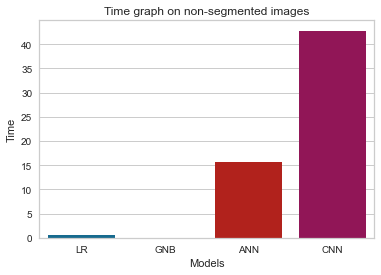

In [210]:
fig=sns.barplot(x=['LR','GNB','ANN','CNN'],y=time_model)
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Time graph on non-segmented images")
plt.show(fig)

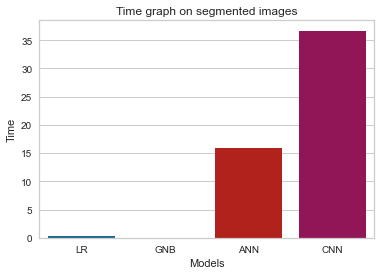

In [212]:
fig=sns.barplot(x=['LR','GNB','ANN','CNN'],y=time_model2)
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Time graph on segmented images")
plt.show(fig)